In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [6]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [7]:
start_date=config.START_DATE
end_date=config.END_DATE

In [8]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO2_20_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
# df.to_csv('susa.csv')

In [10]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,16.81250,16.875000,16.062500,16.274673,7384400,ADBE,0
1,2000-01-03,49.75000,49.875000,48.750000,28.029879,721300,CLX,0
2,2000-01-03,17.72386,17.771505,17.247412,8.905383,1862219,COP,0
3,2000-01-03,10.96875,11.000000,10.640625,8.773580,1046800,EXPD,0
4,2000-01-03,26.62500,26.625000,26.187500,21.393541,26100,FDS,0


In [11]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
105670,2020-12-31,147.479996,148.460007,146.639999,146.058167,2076800,PEP,3
105671,2020-12-31,143.039993,144.440002,141.929993,143.219147,930000,PPG,3
105672,2020-12-31,60.580002,61.480000,60.450001,60.178158,2417300,SO,3
105673,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3
105674,2020-12-31,187.270004,189.699997,184.889999,188.718704,234800,STE,3
105675,2020-12-31,143.220001,143.220001,140.449997,139.758423,713700,TSCO,3
105676,2020-12-31,166.789993,168.479996,165.440002,166.542648,2349400,UPS,3
105677,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3
105678,2020-12-31,58.060001,58.799999,58.020000,57.509003,12906300,VZ,3
105679,2020-12-31,383.720001,385.489990,380.459991,384.329987,176500,ZBRA,3


In [12]:
df.shape

(105680, 8)

In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [14]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,16.81250,16.875000,16.062500,16.274673,7384400,ADBE,0,0.0,17.522824,13.66125,0.0,-66.666667,100.0,16.274673,16.274673,0.722301,0.543661,1.601658
5284,2000-01-03,49.75000,49.875000,48.750000,28.029879,721300,CLX,0,0.0,17.522824,13.66125,0.0,-66.666667,100.0,28.029879,28.029879,0.722301,0.543661,1.601658
10568,2000-01-03,17.72386,17.771505,17.247412,8.905383,1862219,COP,0,0.0,17.522824,13.66125,0.0,-66.666667,100.0,8.905383,8.905383,-0.682290,-1.146615,1.601658
15852,2000-01-03,10.96875,11.000000,10.640625,8.773580,1046800,EXPD,0,0.0,17.522824,13.66125,0.0,-66.666667,100.0,8.773580,8.773580,-0.014800,-0.014911,1.601658
21136,2000-01-03,26.62500,26.625000,26.187500,21.393541,26100,FDS,0,0.0,17.522824,13.66125,0.0,-66.666667,100.0,21.393541,21.393541,1.438405,0.891344,1.601658


In [15]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [16]:
df.shape

(100640, 20)

In [17]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,29.187500,29.250000,22.375000,23.221340,16813400,ADBE,1,-1.941521,38.363061,25.340993,40.521572,-217.354330,36.575796,33.083122,35.040743,0.280687,0.247396,48.541114,"[[0.0032677015670137567, 0.0002536737532421214..."
1,2001-01-02,35.375000,35.375000,34.375000,20.012337,1145400,CLX,1,-1.440794,25.595107,15.733454,42.102959,-53.008050,18.662144,22.672172,23.801964,-0.138192,-0.148723,-0.425857,"[[0.0032677015670137567, 0.0002536737532421214..."
2,2001-01-02,21.773666,22.393049,21.678377,11.537770,2363847,COP,1,-0.095835,11.876813,10.300220,48.443217,19.441595,8.291137,11.463631,12.019566,-0.423467,-0.550723,4.255906,"[[0.0032677015670137567, 0.0002536737532421214..."
3,2001-01-02,13.644531,13.687500,12.250000,10.111978,2412800,EXPD,1,-0.117368,11.588668,9.216021,48.425627,-35.283020,2.154183,10.718556,10.347309,-0.123576,-0.131905,-0.428988,"[[0.0032677015670137567, 0.0002536737532421214..."
4,2001-01-02,24.713333,24.713333,23.373333,19.300266,73500,FDS,1,-0.052958,23.202168,16.677275,48.995618,-13.854197,8.166582,19.745721,19.856563,0.908654,0.646398,0.064434,"[[0.0032677015670137567, 0.0002536737532421214..."
5,2001-01-02,45.687500,46.312500,44.625000,29.696302,6497200,HD,1,0.441272,30.872551,26.079975,52.888817,98.008888,23.677088,27.378734,26.960911,0.538647,0.430904,0.278837,"[[0.0032677015670137567, 0.0002536737532421214..."
6,2001-01-02,53.625000,53.687500,51.250000,52.000000,134100,MTD,1,1.427017,54.874902,43.787598,55.906578,135.259209,23.842806,49.045833,47.737500,0.751060,0.560221,1.598397,"[[0.0032677015670137567, 0.0002536737532421214..."
7,2001-01-02,41.437500,41.937500,39.281250,25.615730,1038600,OMC,1,-0.190790,29.461024,25.178486,45.982795,-52.210240,26.283475,26.901946,26.667213,-0.507390,-0.708037,1.220163,"[[0.0032677015670137567, 0.0002536737532421214..."
8,2001-01-02,13.604281,13.661202,13.319672,3.969823,291848,PEAK,1,0.053123,4.019790,3.647087,57.557567,190.534237,32.955692,3.807281,3.803747,-0.845024,-1.864485,-0.607414,"[[0.0032677015670137567, 0.0002536737532421214..."
9,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,1.565410,0.942118,-0.472327,"[[0.0032677015670137567, 0.0002536737532421214..."


In [18]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [19]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,29.187500,29.250000,22.375000,23.221340,16813400,ADBE,1,-1.941521,38.363061,25.340993,40.521572,-217.354330,36.575796,33.083122,35.040743,0.280687,0.247396,48.541114,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,35.375000,35.375000,34.375000,20.012337,1145400,CLX,1,-1.440794,25.595107,15.733454,42.102959,-53.008050,18.662144,22.672172,23.801964,-0.138192,-0.148723,-0.425857,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,21.773666,22.393049,21.678377,11.537770,2363847,COP,1,-0.095835,11.876813,10.300220,48.443217,19.441595,8.291137,11.463631,12.019566,-0.423467,-0.550723,4.255906,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,13.644531,13.687500,12.250000,10.111978,2412800,EXPD,1,-0.117368,11.588668,9.216021,48.425627,-35.283020,2.154183,10.718556,10.347309,-0.123576,-0.131905,-0.428988,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,24.713333,24.713333,23.373333,19.300266,73500,FDS,1,-0.052958,23.202168,16.677275,48.995618,-13.854197,8.166582,19.745721,19.856563,0.908654,0.646398,0.064434,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,45.687500,46.312500,44.625000,29.696302,6497200,HD,1,0.441272,30.872551,26.079975,52.888817,98.008888,23.677088,27.378734,26.960911,0.538647,0.430904,0.278837,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,53.625000,53.687500,51.250000,52.000000,134100,MTD,1,1.427017,54.874902,43.787598,55.906578,135.259209,23.842806,49.045833,47.737500,0.751060,0.560221,1.598397,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,41.437500,41.937500,39.281250,25.615730,1038600,OMC,1,-0.190790,29.461024,25.178486,45.982795,-52.210240,26.283475,26.901946,26.667213,-0.507390,-0.708037,1.220163,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,13.604281,13.661202,13.319672,3.969823,291848,PEAK,1,0.053123,4.019790,3.647087,57.557567,190.534237,32.955692,3.807281,3.803747,-0.845024,-1.864485,-0.607414,"[[0.0032677015670137567, 0.0002536737532421214..."
0,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,1.565410,0.942118,-0.472327,"[[0.0032677015670137567, 0.0002536737532421214..."


In [20]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,110.580002,111.089996,109.320000,102.682220,5019100,PEP,0,-1.453373,113.166471,97.842704,46.860836,-96.802042,12.408936,106.295728,104.380512,1.130383,0.756302,-0.364371,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,101.820000,102.910004,101.230003,97.968750,1162700,PPG,0,-1.411328,105.603504,88.938670,48.225985,-24.219159,3.500091,99.065055,98.798357,-0.045903,-0.046990,-0.826782,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,43.959999,44.150002,43.430000,39.434021,4394000,SO,0,-0.550168,43.967495,38.429140,44.300645,-145.697584,34.266976,41.320127,40.653909,-0.597484,-0.910020,-0.413138,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,169.119995,170.720001,168.410004,166.156204,944800,SPGI,0,-3.127977,177.997572,153.384993,44.355822,-32.062725,7.490643,168.540599,173.941700,3.213524,1.438299,5.678778,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,105.900002,106.980003,105.519997,104.363487,360100,STE,0,-2.791069,120.733073,96.128123,44.994121,-88.991923,23.691045,109.941537,108.801748,-0.371895,-0.465048,1.165265,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,83.580002,83.910004,82.809998,80.810799,1044100,TSCO,0,-2.383776,94.430477,75.327372,44.065851,-105.354728,21.783208,86.029496,86.682886,-0.225679,-0.255769,-0.213001,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,96.860001,97.559998,96.440002,90.184448,2656700,UPS,0,-3.300423,105.808311,80.383329,40.958876,-71.538073,22.913305,96.149281,99.387524,0.115995,0.109746,-0.079457,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,58.730000,58.950001,57.700001,52.135563,1739200,VTR,0,-0.447188,58.441380,50.343024,48.761658,-150.053730,35.094131,54.311528,52.012421,-0.421901,-0.548010,0.322096,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,55.529999,56.230000,55.070000,50.585201,15331800,VZ,0,-0.720371,54.110994,47.781927,49.637835,-70.498519,14.948583,51.854781,51.142939,-0.029737,-0.030188,-0.695556,"[[0.0004974065825752365, 3.5748808344732334e-0..."
4526,2018-12-31,157.070007,159.330002,155.979996,159.229996,409100,ZBRA,0,-4.679956,185.164031,141.864967,47.288334,-69.146499,15.592075,166.152999,166.279332,2.147758,1.146691,0.525725,"[[0.0004974065825752365, 3.5748808344732334e-0..."


In [21]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,219.910004,226.169998,219.000000,224.570007,2784100,ADBE,2,-5.282335,259.815658,203.146343,45.781002,-54.094692,18.279805,232.429000,239.189334,0.410350,0.343838,1.778960,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,152.990005,153.630005,149.889999,142.436249,1048700,CLX,2,-2.148614,160.492982,137.314972,46.267220,-114.957439,26.139236,150.607187,146.912184,-0.365738,-0.455293,0.579388,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,60.689999,63.849998,60.430000,58.602512,5735400,COP,2,-1.245720,64.091621,53.278916,45.855263,-49.908632,25.492016,59.317556,62.156779,-0.588570,-0.888117,0.124041,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,66.769997,67.900002,66.379997,65.244446,1121300,EXPD,2,-1.420727,74.260809,60.263324,45.351676,-82.644087,14.534151,68.751051,67.590205,0.113339,0.107363,0.289793,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,197.089996,201.529999,197.089996,194.402313,323500,FDS,2,-7.481961,234.984383,178.904408,39.094213,-100.684248,33.022427,212.939919,213.728540,1.979599,1.091789,0.220890,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,169.710007,173.179993,169.050003,162.099030,4242900,HD,2,-1.790349,170.359721,150.384049,46.559993,0.504605,2.341715,161.042228,166.333842,-0.166167,-0.181722,-0.278180,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,557.479980,559.880005,543.520020,546.039978,212200,MTD,2,-11.577475,638.794946,519.199067,43.683289,-110.365920,21.698880,587.633669,577.979003,2.368558,1.214485,2.833575,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,72.589996,73.449997,72.139999,66.708412,2175600,OMC,2,-0.707633,71.595079,63.810885,48.637165,-78.838750,14.425518,68.379925,67.825781,-0.877832,-2.102361,0.138320,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,27.660000,27.660000,26.799999,24.032032,3326400,PEAK,2,-0.230956,27.113578,23.821329,45.980301,-185.718093,34.992582,25.545690,24.671245,-0.639745,-1.020943,-0.631662,"[[0.0004976668843427468, 3.6406349614881e-05, ..."
0,2019-01-02,51.799999,51.799999,50.520000,47.069214,3355900,PEG,2,-0.742562,53.326950,45.795370,42.484773,-127.105074,30.189400,49.638286,49.599216,0.958603,0.672232,-0.757877,"[[0.0004976668843427468, 3.6406349614881e-05, ..."


In [22]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,147.479996,148.460007,146.639999,146.058167,2076800,PEP,3,1.254220,145.743402,141.042728,61.115992,196.894681,36.704361,142.563068,139.597788,1.528204,0.927509,-0.443776,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,143.039993,144.440002,141.929993,143.219147,930000,PPG,3,0.466079,145.813420,140.730130,55.872296,-62.045510,1.155041,143.817960,139.074662,-0.019438,-0.019629,-0.874334,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,60.580002,61.480000,60.450001,60.178158,2417300,SO,3,-0.022074,60.733534,57.896690,56.085237,53.260741,14.855354,59.436585,58.868821,-0.579818,-0.867066,-0.026322,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3,-3.714645,335.799567,310.036267,47.999502,-18.527978,2.500436,327.490699,333.881650,4.438922,1.693581,10.034329,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,187.270004,189.699997,184.889999,188.718704,234800,STE,3,-0.454153,192.211487,179.690041,54.691534,-12.199284,1.295900,187.781832,186.296536,-0.423415,-0.550633,2.266640,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,143.220001,143.220001,140.449997,139.758423,713700,TSCO,3,1.853094,150.556303,131.135735,50.673351,29.504620,1.832962,138.534892,138.740911,-0.259435,-0.300342,-0.043132,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,166.789993,168.479996,165.440002,166.542648,2349400,UPS,3,0.591279,173.946265,161.448294,51.642665,-57.675000,0.488543,167.352955,166.506991,0.191647,0.175336,0.162852,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3,0.470189,50.150636,46.908443,55.363863,-42.644192,2.963657,48.252830,45.574378,-0.707962,-1.230873,-0.191788,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,58.060001,58.799999,58.020000,57.509003,12906300,VZ,3,-0.405310,60.927017,56.565592,46.770789,-155.678783,18.422305,58.897704,58.124588,0.182420,0.167563,-0.824295,"[[0.0009139890860421435, 0.000215859381497942,..."
504,2020-12-31,383.720001,385.489990,380.459991,384.329987,176500,ZBRA,3,7.802211,385.613850,370.790148,63.571885,100.329410,16.995806,373.956333,341.365499,5.682953,1.899560,1.036523,"[[0.0009139890860421435, 0.000215859381497942,..."


In [23]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [24]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 20


In [25]:
train.tic.unique()

array(['ADBE', 'CLX', 'COP', 'EXPD', 'FDS', 'HD', 'MTD', 'OMC', 'PEAK',
       'PEG', 'PEP', 'PPG', 'SO', 'SPGI', 'STE', 'TSCO', 'UPS', 'VTR',
       'VZ', 'ZBRA'], dtype=object)

In [26]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [27]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [28]:
# initialize
agent = DRLAgent(env = env_train)

In [29]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}

model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device
Logging to tensorboard_log/a2c\a2c_25
------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -28.3    |
|    explained_variance | 3.4e-06  |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 1.06e+07 |
|    std                | 0.998    |
|    value_loss         | 1.46e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 169      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -28.3    |
|    explained_variance | 4.17e-07 

------------------------------------
| time/                 |          |
|    fps                | 256      |
|    iterations         | 1500     |
|    time_elapsed       | 29       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 4.28e+07 |
|    std                | 0.991    |
|    value_loss         | 2.95e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 258      |
|    iterations         | 1600     |
|    time_elapsed       | 30       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 5.98e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 265      |
|    iterations         | 2900     |
|    time_elapsed       | 54       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -28.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 1.4e+07  |
|    std                | 0.987    |
|    value_loss         | 3.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 265      |
|    iterations         | 3000     |
|    time_elapsed       | 56       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -28.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 2.25e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 262      |
|    iterations         | 4300     |
|    time_elapsed       | 81       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 5.5e+07  |
|    std                | 0.98     |
|    value_loss         | 5.08e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 263       |
|    iterations         | 4400      |
|    time_elapsed       | 83        |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -28       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 4399      |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 262      |
|    iterations         | 5600     |
|    time_elapsed       | 106      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -27.8    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 1.4e+07  |
|    std                | 0.971    |
|    value_loss         | 3.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 262      |
|    iterations         | 5700     |
|    time_elapsed       | 108      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -27.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 1.95e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 260      |
|    iterations         | 7000     |
|    time_elapsed       | 134      |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 5.36e+07 |
|    std                | 0.968    |
|    value_loss         | 4.24e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 259      |
|    iterations         | 7100     |
|    time_elapsed       | 136      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss        | 6.28e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 255       |
|    iterations         | 8300      |
|    time_elapsed       | 162       |
|    total_timesteps    | 41500     |
| train/                |           |
|    entropy_loss       | -27.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 8299      |
|    policy_loss        | 1.57e+07  |
|    std                | 0.963     |
|    value_loss         | 3.21e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 255      |
|    iterations         | 8400     |
|    time_elapsed       | 164      |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -27.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 251      |
|    iterations         | 9700     |
|    time_elapsed       | 192      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -27.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 5.37e+07 |
|    std                | 0.954    |
|    value_loss         | 4.87e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 251      |
|    iterations         | 9800     |
|    time_elapsed       | 194      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -27.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss        | 7.53e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 246       |
|    iterations         | 11000     |
|    time_elapsed       | 222       |
|    total_timesteps    | 55000     |
| train/                |           |
|    entropy_loss       | -27.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 10999     |
|    policy_loss        | 1.3e+07   |
|    std                | 0.948     |
|    value_loss         | 2.73e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 11100    |
|    time_elapsed       | 225      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 244      |
|    iterations         | 12400    |
|    time_elapsed       | 253      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 4.49e+07 |
|    std                | 0.946    |
|    value_loss         | 3.16e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 244      |
|    iterations         | 12500    |
|    time_elapsed       | 255      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 5.93e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 239       |
|    iterations         | 13700     |
|    time_elapsed       | 285       |
|    total_timesteps    | 68500     |
| train/                |           |
|    entropy_loss       | -27.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 13699     |
|    policy_loss        | 1.1e+07   |
|    std                | 0.94      |
|    value_loss         | 2.19e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 239      |
|    iterations         | 13800    |
|    time_elapsed       | 288      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -27.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 236       |
|    iterations         | 15100     |
|    time_elapsed       | 318       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | -27       |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15099     |
|    policy_loss        | 5.04e+07  |
|    std                | 0.932     |
|    value_loss         | 4.01e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 236       |
|    iterations         | 15200     |
|    time_elapsed       | 320       |
|    total_timesteps    | 76000     |
| train/                |           |
|    entropy_loss       | -27       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15199     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 234      |
|    iterations         | 16400    |
|    time_elapsed       | 349      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 9.16e+06 |
|    std                | 0.926    |
|    value_loss         | 1.76e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 234      |
|    iterations         | 16500    |
|    time_elapsed       | 351      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 1.51e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 233       |
|    iterations         | 17800     |
|    time_elapsed       | 381       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17799     |
|    policy_loss        | 3.37e+07  |
|    std                | 0.919     |
|    value_loss         | 2.01e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 233       |
|    iterations         | 17900     |
|    time_elapsed       | 383       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 232      |
|    iterations         | 19200    |
|    time_elapsed       | 413      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -26.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19199    |
|    policy_loss        | 1.49e+07 |
|    std                | 0.913    |
|    value_loss         | 3.91e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 232      |
|    iterations         | 19300    |
|    time_elapsed       | 415      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -26.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss        | 2.05e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 231      |
|    iterations         | 20600    |
|    time_elapsed       | 444      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -26.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 5.41e+07 |
|    std                | 0.907    |
|    value_loss         | 4.92e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 231      |
|    iterations         | 20700    |
|    time_elapsed       | 446      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -26.4    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 7.97e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 230       |
|    iterations         | 21900     |
|    time_elapsed       | 474       |
|    total_timesteps    | 109500    |
| train/                |           |
|    entropy_loss       | -26.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 21899     |
|    policy_loss        | 1.39e+07  |
|    std                | 0.899     |
|    value_loss         | 3.63e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 230       |
|    iterations         | 22000     |
|    time_elapsed       | 476       |
|    total_timesteps    | 110000    |
| train/                |           |
|    entropy_loss       | -26.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 21999     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 230       |
|    iterations         | 23300     |
|    time_elapsed       | 505       |
|    total_timesteps    | 116500    |
| train/                |           |
|    entropy_loss       | -26.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 23299     |
|    policy_loss        | 4.37e+07  |
|    std                | 0.891     |
|    value_loss         | 3.33e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 230      |
|    iterations         | 23400    |
|    time_elapsed       | 507      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -26.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 229      |
|    iterations         | 24600    |
|    time_elapsed       | 535      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -26      |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 1.23e+07 |
|    std                | 0.886    |
|    value_loss         | 2.91e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 229       |
|    iterations         | 24700     |
|    time_elapsed       | 538       |
|    total_timesteps    | 123500    |
| train/                |           |
|    entropy_loss       | -26       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 24699     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 26000    |
|    time_elapsed       | 567      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -25.8    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 4.92e+07 |
|    std                | 0.881    |
|    value_loss         | 4.53e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 26100    |
|    time_elapsed       | 570      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -25.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 5.77e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 27300    |
|    time_elapsed       | 597      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -25.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 1.12e+07 |
|    std                | 0.876    |
|    value_loss         | 2.39e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 27400    |
|    time_elapsed       | 600      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -25.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27399    |
|    policy_loss        | 1.66e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 226      |
|    iterations         | 28700    |
|    time_elapsed       | 634      |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -25.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28699    |
|    policy_loss        | 4.14e+07 |
|    std                | 0.867    |
|    value_loss         | 3.08e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 225       |
|    iterations         | 28800     |
|    time_elapsed       | 637       |
|    total_timesteps    | 144000    |
| train/                |           |
|    entropy_loss       | -25.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28799     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 223       |
|    iterations         | 30000     |
|    time_elapsed       | 669       |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -25.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 29999     |
|    policy_loss        | 1.14e+07  |
|    std                | 0.861     |
|    value_loss         | 2.27e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 223       |
|    iterations         | 30100     |
|    time_elapsed       | 672       |
|    total_timesteps    | 150500    |
| train/                |           |
|    entropy_loss       | -25.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 30099     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 31400    |
|    time_elapsed       | 701      |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -25.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 3.67e+07 |
|    std                | 0.855    |
|    value_loss         | 2.84e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 31500    |
|    time_elapsed       | 704      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -25.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss        | 6.11e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 223       |
|    iterations         | 32700     |
|    time_elapsed       | 731       |
|    total_timesteps    | 163500    |
| train/                |           |
|    entropy_loss       | -25.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 32699     |
|    policy_loss        | 8.77e+06  |
|    std                | 0.848     |
|    value_loss         | 1.52e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 32800    |
|    time_elapsed       | 733      |
|    total_timesteps    | 164000   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 34100    |
|    time_elapsed       | 763      |
|    total_timesteps    | 170500   |
| train/                |          |
|    entropy_loss       | -24.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34099    |
|    policy_loss        | 3.35e+07 |
|    std                | 0.843    |
|    value_loss         | 2.33e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 34200    |
|    time_elapsed       | 765      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -24.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss        | 5.29e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 35500    |
|    time_elapsed       | 795      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -24.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 1.39e+07 |
|    std                | 0.837    |
|    value_loss         | 4.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 35600    |
|    time_elapsed       | 797      |
|    total_timesteps    | 178000   |
| train/                |          |
|    entropy_loss       | -24.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35599    |
|    policy_loss        | 1.9e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 36900    |
|    time_elapsed       | 827      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 4.44e+07 |
|    std                | 0.831    |
|    value_loss         | 4.26e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 37000    |
|    time_elapsed       | 829      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -24.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 6.3e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 38200    |
|    time_elapsed       | 857      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -24.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 1.33e+07 |
|    std                | 0.827    |
|    value_loss         | 3.65e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 38300    |
|    time_elapsed       | 859      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -24.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss        | 1.74e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 39600    |
|    time_elapsed       | 889      |
|    total_timesteps    | 198000   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39599    |
|    policy_loss        | 4.01e+07 |
|    std                | 0.822    |
|    value_loss         | 3.65e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 39700    |
|    time_elapsed       | 891      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss        | 5.23e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 222       |
|    iterations         | 40900     |
|    time_elapsed       | 918       |
|    total_timesteps    | 204500    |
| train/                |           |
|    entropy_loss       | -24.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 40899     |
|    policy_loss        | 1.24e+07  |
|    std                | 0.817     |
|    value_loss         | 3.82e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 41000    |
|    time_elapsed       | 921      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -24.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 42300    |
|    time_elapsed       | 951      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 4.16e+07 |
|    std                | 0.813    |
|    value_loss         | 3.59e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 42400    |
|    time_elapsed       | 953      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 5.35e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 43600    |
|    time_elapsed       | 981      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -24.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 1.16e+07 |
|    std                | 0.808    |
|    value_loss         | 2.42e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 222      |
|    iterations         | 43700    |
|    time_elapsed       | 983      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -24.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 1.29e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 45000    |
|    time_elapsed       | 1013     |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -24      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 3.58e+07 |
|    std                | 0.802    |
|    value_loss         | 2.71e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 221       |
|    iterations         | 45100     |
|    time_elapsed       | 1015      |
|    total_timesteps    | 225500    |
| train/                |           |
|    entropy_loss       | -23.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 45099     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 46300    |
|    time_elapsed       | 1043     |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 9.15e+06 |
|    std                | 0.797    |
|    value_loss         | 2.11e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 46400    |
|    time_elapsed       | 1045     |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 1.62e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 221       |
|    iterations         | 47700     |
|    time_elapsed       | 1075      |
|    total_timesteps    | 238500    |
| train/                |           |
|    entropy_loss       | -23.7     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47699     |
|    policy_loss        | 3.63e+07  |
|    std                | 0.794     |
|    value_loss         | 2.57e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 47800    |
|    time_elapsed       | 1078     |
|    total_timesteps    | 239000   |
| train/                |          |
|    entropy_loss       | -23.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 47799    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 221       |
|    iterations         | 49000     |
|    time_elapsed       | 1105      |
|    total_timesteps    | 245000    |
| train/                |           |
|    entropy_loss       | -23.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 48999     |
|    policy_loss        | 9.06e+06  |
|    std                | 0.789     |
|    value_loss         | 1.61e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 221       |
|    iterations         | 49100     |
|    time_elapsed       | 1107      |
|    total_timesteps    | 245500    |
| train/                |           |
|    entropy_loss       | -23.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 49099     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 50400    |
|    time_elapsed       | 1138     |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 2.9e+07  |
|    std                | 0.786    |
|    value_loss         | 2.34e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 50500    |
|    time_elapsed       | 1140     |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50499    |
|    policy_loss        | 4.6e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 51800    |
|    time_elapsed       | 1170     |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -23.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 1.39e+07 |
|    std                | 0.782    |
|    value_loss         | 3.51e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 51900    |
|    time_elapsed       | 1172     |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -23.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 1.74e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 53200    |
|    time_elapsed       | 1203     |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -23.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 4.93e+07 |
|    std                | 0.778    |
|    value_loss         | 5.21e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 221      |
|    iterations         | 53300    |
|    time_elapsed       | 1205     |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -23.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 6.27e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 54500    |
|    time_elapsed       | 1233     |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -23.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 1.29e+07 |
|    std                | 0.774    |
|    value_loss         | 3.34e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 54600    |
|    time_elapsed       | 1235     |
|    total_timesteps    | 273000   |
| train/                |          |
|    entropy_loss       | -23.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54599    |
|    policy_loss        | 1.51e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 55900    |
|    time_elapsed       | 1268     |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 5.39e+07 |
|    std                | 0.77     |
|    value_loss         | 5.25e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 56000    |
|    time_elapsed       | 1270     |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 7.14e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 57200    |
|    time_elapsed       | 1298     |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -23      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 1.16e+07 |
|    std                | 0.766    |
|    value_loss         | 2.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 57300    |
|    time_elapsed       | 1301     |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -23      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss        | 1.7e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 58600    |
|    time_elapsed       | 1331     |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 3.53e+07 |
|    std                | 0.759    |
|    value_loss         | 3.85e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 58700    |
|    time_elapsed       | 1334     |
|    total_timesteps    | 293500   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58699    |
|    policy_loss        | 4.85e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 59900    |
|    time_elapsed       | 1362     |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -22.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 1.08e+07 |
|    std                | 0.755    |
|    value_loss         | 2.3e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 60000    |
|    time_elapsed       | 1364     |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -22.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 1.21e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 61300    |
|    time_elapsed       | 1394     |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -22.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 3.6e+07  |
|    std                | 0.75     |
|    value_loss         | 3.77e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 61400    |
|    time_elapsed       | 1397     |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -22.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 4.93e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 62600    |
|    time_elapsed       | 1425     |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 9.8e+06  |
|    std                | 0.746    |
|    value_loss         | 1.93e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 62700    |
|    time_elapsed       | 1427     |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss        | 1.18e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 64000    |
|    time_elapsed       | 1458     |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 3.82e+07 |
|    std                | 0.739    |
|    value_loss         | 3.22e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 64100    |
|    time_elapsed       | 1460     |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss        | 5.48e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 65300    |
|    time_elapsed       | 1489     |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -22.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 7.65e+06 |
|    std                | 0.736    |
|    value_loss         | 1.47e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 65400    |
|    time_elapsed       | 1491     |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -22.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 1.49e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 66700    |
|    time_elapsed       | 1521     |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -22.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 2.37e+07 |
|    std                | 0.733    |
|    value_loss         | 1.99e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 66800    |
|    time_elapsed       | 1524     |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -22.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 4.48e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 68100    |
|    time_elapsed       | 1555     |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -22      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 1.24e+07 |
|    std                | 0.73     |
|    value_loss         | 4.25e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 68200    |
|    time_elapsed       | 1557     |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -22      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss        | 1.6e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 218       |
|    iterations         | 69500     |
|    time_elapsed       | 1587      |
|    total_timesteps    | 347500    |
| train/                |           |
|    entropy_loss       | -21.9     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69499     |
|    policy_loss        | 4.45e+07  |
|    std                | 0.724     |
|    value_loss         | 4.92e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 69600    |
|    time_elapsed       | 1590     |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -21.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 70800    |
|    time_elapsed       | 1618     |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -21.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 1.12e+07 |
|    std                | 0.718    |
|    value_loss         | 3.09e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 70900    |
|    time_elapsed       | 1620     |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -21.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 70899    |
|    policy_loss        | 1.5e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 72200    |
|    time_elapsed       | 1651     |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -21.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 3.75e+07 |
|    std                | 0.715    |
|    value_loss         | 3.23e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 72300    |
|    time_elapsed       | 1654     |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -21.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss        | 4.51e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 73500    |
|    time_elapsed       | 1683     |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 1.07e+07 |
|    std                | 0.71     |
|    value_loss         | 3.19e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 73600    |
|    time_elapsed       | 1685     |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss        | 1.32e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 74900    |
|    time_elapsed       | 1715     |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -21.3    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 3.99e+07 |
|    std                | 0.704    |
|    value_loss         | 3.23e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 75000    |
|    time_elapsed       | 1717     |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -21.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 4e+07    |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 76200    |
|    time_elapsed       | 1747     |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 1.06e+07 |
|    std                | 0.701    |
|    value_loss         | 2.69e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 218       |
|    iterations         | 76300     |
|    time_elapsed       | 1749      |
|    total_timesteps    | 381500    |
| train/                |           |
|    entropy_loss       | -21.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 76299     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 77600    |
|    time_elapsed       | 1779     |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -21.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 3.14e+07 |
|    std                | 0.696    |
|    value_loss         | 2.7e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 77700    |
|    time_elapsed       | 1781     |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -21.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 4.15e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 78900     |
|    time_elapsed       | 1810      |
|    total_timesteps    | 394500    |
| train/                |           |
|    entropy_loss       | -20.9     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78899     |
|    policy_loss        | 8.9e+06   |
|    std                | 0.691     |
|    value_loss         | 2.32e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 79000     |
|    time_elapsed       | 1812      |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -20.9     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78999     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 80300    |
|    time_elapsed       | 1842     |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -20.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 3.32e+07 |
|    std                | 0.687    |
|    value_loss         | 3.42e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 80400     |
|    time_elapsed       | 1845      |
|    total_timesteps    | 402000    |
| train/                |           |
|    entropy_loss       | -20.8     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 80399     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 81600    |
|    time_elapsed       | 1874     |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -20.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 7.43e+06 |
|    std                | 0.682    |
|    value_loss         | 1.7e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 81700     |
|    time_elapsed       | 1876      |
|    total_timesteps    | 408500    |
| train/                |           |
|    entropy_loss       | -20.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 81699     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 83000     |
|    time_elapsed       | 1906      |
|    total_timesteps    | 415000    |
| train/                |           |
|    entropy_loss       | -20.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 82999     |
|    policy_loss        | 2.74e+07  |
|    std                | 0.676     |
|    value_loss         | 2.56e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 83100    |
|    time_elapsed       | 1909     |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -20.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 83099    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 84400     |
|    time_elapsed       | 1940      |
|    total_timesteps    | 422000    |
| train/                |           |
|    entropy_loss       | -20.4     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84399     |
|    policy_loss        | 1.39e+07  |
|    std                | 0.673     |
|    value_loss         | 5.13e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 84500    |
|    time_elapsed       | 1942     |
|    total_timesteps    | 422500   |
| train/                |          |
|    entropy_loss       | -20.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 84499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 85800    |
|    time_elapsed       | 1973     |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -20.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 4.36e+07 |
|    std                | 0.669    |
|    value_loss         | 4.51e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 85900    |
|    time_elapsed       | 1975     |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -20.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 5.26e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 87100     |
|    time_elapsed       | 2005      |
|    total_timesteps    | 435500    |
| train/                |           |
|    entropy_loss       | -20.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 87099     |
|    policy_loss        | 1.03e+07  |
|    std                | 0.668     |
|    value_loss         | 3.22e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 217       |
|    iterations         | 87200     |
|    time_elapsed       | 2007      |
|    total_timesteps    | 436000    |
| train/                |           |
|    entropy_loss       | -20.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 87199     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 88500    |
|    time_elapsed       | 2037     |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 4.09e+07 |
|    std                | 0.664    |
|    value_loss         | 4.68e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 217      |
|    iterations         | 88600    |
|    time_elapsed       | 2040     |
|    total_timesteps    | 443000   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88599    |
|    policy_loss        | 4.46e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 89800    |
|    time_elapsed       | 2069     |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -20      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 9.27e+06 |
|    std                | 0.659    |
|    value_loss         | 3.14e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 216       |
|    iterations         | 89900     |
|    time_elapsed       | 2071      |
|    total_timesteps    | 449500    |
| train/                |           |
|    entropy_loss       | -20       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89899     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 91200    |
|    time_elapsed       | 2101     |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -19.9    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 3.58e+07 |
|    std                | 0.656    |
|    value_loss         | 3.44e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 91300    |
|    time_elapsed       | 2104     |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -19.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 3.88e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 92500    |
|    time_elapsed       | 2133     |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -19.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 9.91e+06 |
|    std                | 0.652    |
|    value_loss         | 2.75e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 92600    |
|    time_elapsed       | 2135     |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -19.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 1.45e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 216       |
|    iterations         | 93900     |
|    time_elapsed       | 2165      |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -19.6     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 93899     |
|    policy_loss        | 3.35e+07  |
|    std                | 0.647     |
|    value_loss         | 3.33e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 94000    |
|    time_elapsed       | 2168     |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -19.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 95200    |
|    time_elapsed       | 2197     |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -19.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 9.21e+06 |
|    std                | 0.644    |
|    value_loss         | 2.5e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 216       |
|    iterations         | 95300     |
|    time_elapsed       | 2199      |
|    total_timesteps    | 476500    |
| train/                |           |
|    entropy_loss       | -19.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 95299     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 216       |
|    iterations         | 96600     |
|    time_elapsed       | 2229      |
|    total_timesteps    | 483000    |
| train/                |           |
|    entropy_loss       | -19.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96599     |
|    policy_loss        | 3.57e+07  |
|    std                | 0.639     |
|    value_loss         | 4.58e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 96700    |
|    time_elapsed       | 2232     |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -19.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 97900    |
|    time_elapsed       | 2261     |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -19.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 7.59e+06 |
|    std                | 0.633    |
|    value_loss         | 2.05e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 98000    |
|    time_elapsed       | 2263     |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -19.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss        | 1.34e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 99300    |
|    time_elapsed       | 2294     |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -19      |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 2.61e+07 |
|    std                | 0.629    |
|    value_loss         | 2.6e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 216      |
|    iterations         | 99400    |
|    time_elapsed       | 2296     |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -19      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 4.13e+07 |
|

In [30]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:151978.43654826222
Sharpe:  0.9343618675180746
hit end!


In [32]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.016205
2,2019-01-04,0.022636
3,2019-01-07,0.005674
4,2019-01-08,0.013554


In [33]:
df_actions.head()

,ADBE,CLX,COP,EXPD,FDS,HD,MTD,OMC,PEAK,PEG,PEP,PPG,SO,SPGI,STE,TSCO,UPS,VTR,VZ,ZBRA
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.048705,0.029159,0.077902,0.029159,0.029159,0.078150,0.076339,0.046890,0.079261,0.079261,0.077032,0.029159,0.052407,0.029159,0.042364,0.029159,0.079261,0.029159,0.029159,0.029159
2019-01-04,0.034458,0.034485,0.093668,0.034458,0.057621,0.093668,0.044902,0.034458,0.051441,0.051515,0.034458,0.034458,0.093668,0.034458,0.040780,0.034458,0.093668,0.034458,0.034458,0.034458
2019-01-07,0.031938,0.035078,0.031695,0.029698,0.049738,0.059505,0.080727,0.080727,0.080727,0.080727,0.029698,0.029698,0.080727,0.029698,0.070105,0.029698,0.080727,0.029698,0.029698,0.029698
2019-01-08,0.036306,0.036306,0.036306,0.036306,0.092577,0.036306,0.098690,0.057145,0.098690,0.046736,0.036306,0.036306,0.061526,0.036306,0.036306,0.036306,0.072660,0.036306,0.036306,0.036306


In [34]:
df_actions.to_csv('df_actions_a2c_20_2.csv')

In [35]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [36]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.232285
Cumulative returns      0.519784
Annual volatility       0.260131
Sharpe ratio            0.934362
Calmar ratio            0.672170
Stability               0.379804
Max drawdown           -0.345574
Omega ratio             1.224078
Sortino ratio           1.296644
Skew                   -0.781132
Kurtosis               14.162055
Tail ratio              0.924847
Daily value at risk    -0.031809
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,23.228%
Cumulative returns,51.978%
Annual volatility,26.013%
Sharpe ratio,0.93
Calmar ratio,0.67
Stability,0.38
Max drawdown,-34.557%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.56,2020-01-23,2020-03-23,2020-07-31,137
1,7.17,2020-10-12,2020-10-30,2020-11-09,21
2,6.01,2020-09-02,2020-09-23,2020-10-07,26
3,5.58,2019-07-03,2019-08-05,2019-09-17,55
4,4.70,2019-09-17,2019-10-08,2019-11-26,51


Stress Events,mean,min,max
New Normal,0.10%,-12.19%,8.84%


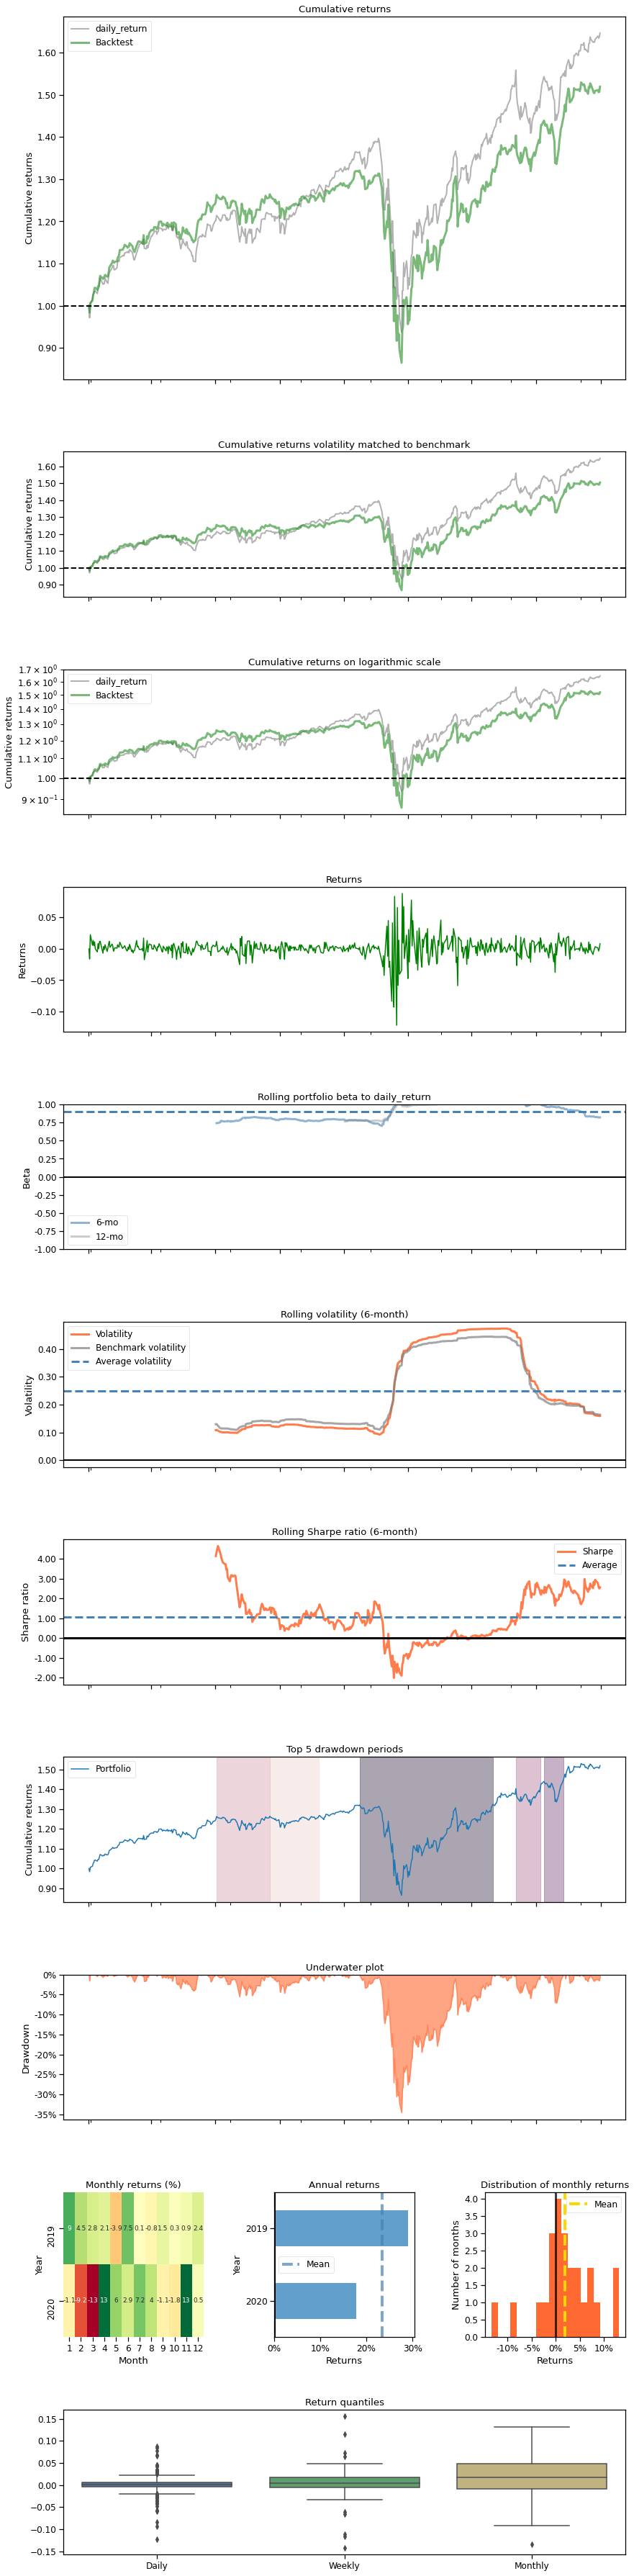

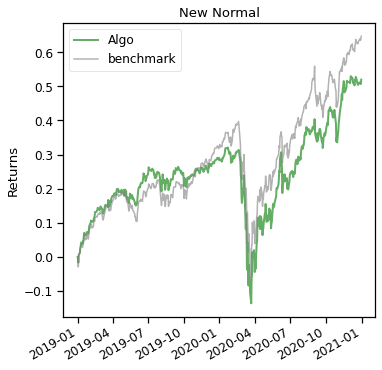

In [37]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [38]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1"
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_9
begin_total_asset:100000
end_total_asset:1254626.665229115
Sharpe:  0.8569123604156998
begin_total_asset:100000
end_total_asset:1338039.7267861501
Sharpe:  0.8767997485713254
begin_total_asset:100000
end_total_asset:1338229.335227753
Sharpe:  0.8768589115183589
begin_total_asset:100000
end_total_asset:1339112.7060847138
Sharpe:  0.8771428309479808
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.34e+06                |
|    total_reward    | [0, 0.03996086447574... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 28                      |
|    time_elapsed    | 633                     |
|    total timesteps | 18108                   |
| train/             |                 

In [39]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [41]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:157866.88721455948
Sharpe:  1.007430482344674
hit end!


In [42]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.018457
2,2019-01-04,0.023656
3,2019-01-07,0.006433
4,2019-01-08,0.011631
...,...,...
500,2020-12-24,0.003167
501,2020-12-28,0.000175
502,2020-12-29,-0.003347
503,2020-12-30,0.002578


In [43]:
df_actions.head()

,ADBE,CLX,COP,EXPD,FDS,HD,MTD,OMC,PEAK,PEG,PEP,PPG,SO,SPGI,STE,TSCO,UPS,VTR,VZ,ZBRA
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.026574,0.027580,0.054741,0.070137,0.027861,0.070095,0.028381,0.065998,0.070351,0.026636,0.026661,0.070154,0.071461,0.069739,0.069163,0.071081,0.031889,0.026455,0.026810,0.068232
2019-01-04,0.027372,0.028050,0.060812,0.073474,0.030183,0.058451,0.028676,0.073264,0.072760,0.027547,0.027678,0.063134,0.060741,0.073984,0.061124,0.073388,0.029461,0.029205,0.028265,0.072431
2019-01-07,0.027686,0.026587,0.066524,0.069987,0.028286,0.067711,0.026565,0.070058,0.070285,0.028408,0.027778,0.050819,0.071443,0.071392,0.066993,0.070932,0.038876,0.026680,0.027220,0.065768
2019-01-08,0.027299,0.028397,0.071315,0.056427,0.027141,0.066315,0.027528,0.069601,0.064023,0.029406,0.026900,0.063447,0.065892,0.071160,0.071314,0.070470,0.035676,0.027422,0.028031,0.072236


In [44]:
df_actions.to_csv('df_actions_sac_20_2.csv')

In [45]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [46]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.255883
Cumulative returns      0.578669
Annual volatility       0.260147
Sharpe ratio            1.007430
Calmar ratio            0.754318
Stability               0.575950
Max drawdown           -0.339224
Omega ratio             1.244353
Sortino ratio           1.397064
Skew                   -0.859371
Kurtosis               15.696531
Tail ratio              0.900596
Daily value at risk    -0.031735
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,25.588%
Cumulative returns,57.867%
Annual volatility,26.015%
Sharpe ratio,1.01
Calmar ratio,0.75
Stability,0.58
Max drawdown,-33.922%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.92,2020-02-20,2020-03-23,2020-06-05,77
1,8.74,2020-06-08,2020-06-11,2020-07-29,38
2,7.57,2020-10-12,2020-10-30,2020-11-10,22
3,6.45,2020-09-02,2020-09-23,2020-10-08,27
4,4.84,2019-07-03,2019-08-05,2019-09-05,47


Stress Events,mean,min,max
New Normal,0.10%,-12.43%,9.84%


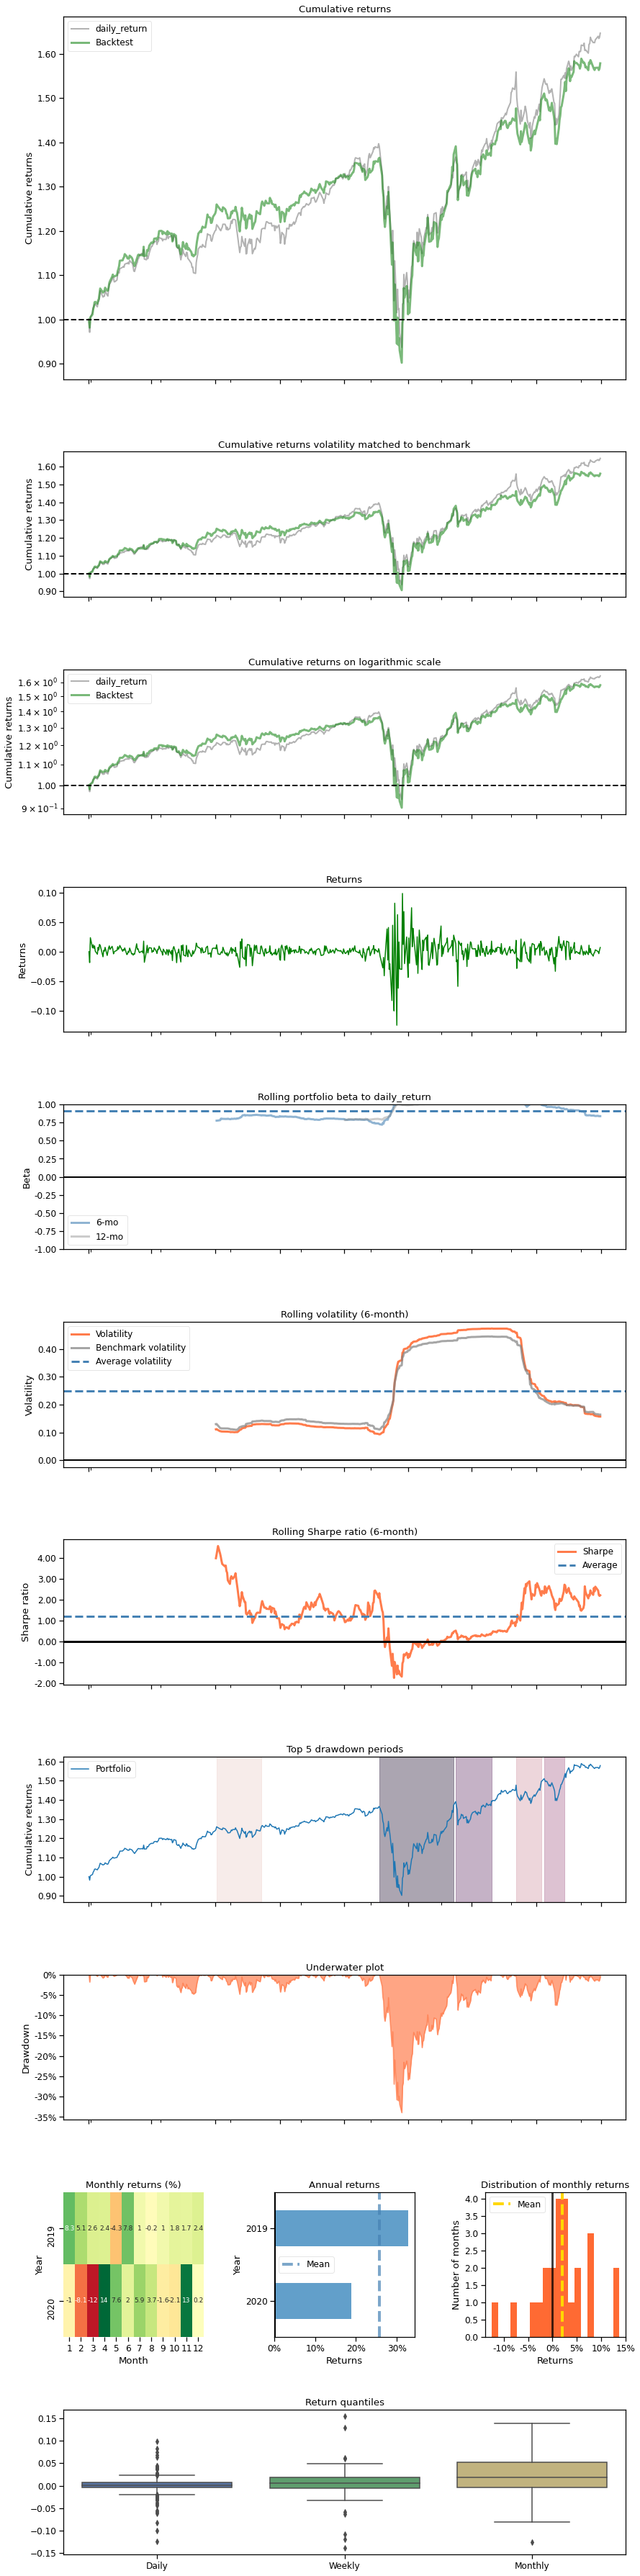

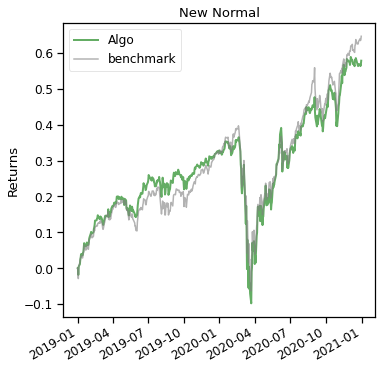

In [47]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [48]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_9
-----------------------------
| time/              |      |
|    fps             | 342  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 302            |
|    iterations           | 2              |
|    time_elapsed         | 13             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -5.5506825e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -28.4          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 5.73e+12       |
|    n_updates           

-------------------------------------------
| time/                   |               |
|    fps                  | 274           |
|    iterations           | 10            |
|    time_elapsed         | 74            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | -8.288771e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0001        |
|    loss                 | 9.63e+13      |
|    n_updates            | 90            |
|    policy_gradient_loss | -1.04e-06     |
|    std                  | 1             |
|    value_loss           | 1.77e+14      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 273           |
|    iterations           | 11  

begin_total_asset:100000
end_total_asset:1193718.0965934803
Sharpe:  0.864389455609297
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.19e+06                |
|    total_reward         | [0, 0.04428353575259... |
| time/                   |                         |
|    fps                  | 277                     |
|    iterations           | 18                      |
|    time_elapsed         | 132                     |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -1.8533319e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.75e+13             

-------------------------------------------
| time/                   |               |
|    fps                  | 274           |
|    iterations           | 26            |
|    time_elapsed         | 193           |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 3.8184226e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 4.84e+13      |
|    n_updates            | 250           |
|    policy_gradient_loss | -1.55e-06     |
|    std                  | 1             |
|    value_loss           | 1.15e+14      |
-------------------------------------------
begin_total_asset:100000
end_total_asset:1046446.9066954311
Sharpe:  0.8191239401643621
-----------------------------------------------------
| environment/        

begin_total_asset:100000
end_total_asset:1074535.1337773565
Sharpe:  0.8290072858075062
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.07e+06                |
|    total_reward         | [0, 0.04336152134335... |
| time/                   |                         |
|    fps                  | 267                     |
|    iterations           | 34                      |
|    time_elapsed         | 260                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | -4.1816384e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | -2.38e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 5.38e+13            

begin_total_asset:100000
end_total_asset:1115239.4502787667
Sharpe:  0.8414232026293247
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.12e+06                |
|    total_reward         | [0, 0.03849301955893... |
| time/                   |                         |
|    fps                  | 260                     |
|    iterations           | 42                      |
|    time_elapsed         | 330                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 5.3923577e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | -2.38e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 8.63e+12            

In [49]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [50]:
trade.shape

(10100, 20)

In [58]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:158084.90642698825
Sharpe:  1.0274277229385147
hit end!


In [59]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.017046
2,2019-01-04,0.020851
3,2019-01-07,0.005201
4,2019-01-08,0.009545
...,...,...
500,2020-12-24,0.005058
501,2020-12-28,0.001016
502,2020-12-29,-0.003081
503,2020-12-30,0.001429


In [60]:
df_actions.head()

,ADBE,CLX,COP,EXPD,FDS,HD,MTD,OMC,PEAK,PEG,PEP,PPG,SO,SPGI,STE,TSCO,UPS,VTR,VZ,ZBRA
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.044975,0.044975,0.058839,0.044975,0.047500,0.044975,0.044975,0.044975,0.044975,0.044975,0.044975,0.044975,0.071689,0.086369,0.044975,0.044975,0.044975,0.045717,0.060234,0.044975
2019-01-04,0.050866,0.047641,0.041469,0.039338,0.039338,0.039338,0.059151,0.039338,0.039338,0.085569,0.039338,0.039338,0.039338,0.039338,0.081150,0.039338,0.053991,0.066383,0.081058,0.039338
2019-01-07,0.038427,0.038427,0.045935,0.038427,0.038427,0.038427,0.038427,0.038427,0.051930,0.051211,0.104457,0.075910,0.038427,0.038427,0.038427,0.078770,0.038427,0.086825,0.043833,0.038427
2019-01-08,0.060785,0.099341,0.081538,0.036545,0.036545,0.036545,0.036545,0.036545,0.036545,0.054044,0.061366,0.036545,0.036545,0.036545,0.036545,0.036545,0.036545,0.036545,0.068494,0.099341


In [61]:
df_actions.to_csv('df_actions_ppo_20_2.csv')

In [62]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [63]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.256748
Cumulative returns      0.580849
Annual volatility       0.254221
Sharpe ratio            1.027428
Calmar ratio            0.813740
Stability               0.632792
Max drawdown           -0.315516
Omega ratio             1.248285
Sortino ratio           1.434717
Skew                   -0.792384
Kurtosis               14.750052
Tail ratio              1.068298
Daily value at risk    -0.030992
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,25.675%
Cumulative returns,58.085%
Annual volatility,25.422%
Sharpe ratio,1.03
Calmar ratio,0.81
Stability,0.63
Max drawdown,-31.552%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.55,2020-02-20,2020-03-23,2020-06-05,77
1,8.31,2020-06-08,2020-06-11,2020-07-31,40
2,6.98,2020-10-12,2020-10-30,2020-11-09,21
3,6.05,2020-09-02,2020-09-23,2020-10-07,26
4,5.98,2019-07-03,2019-08-05,2019-11-15,98


Stress Events,mean,min,max
New Normal,0.10%,-11.77%,9.18%


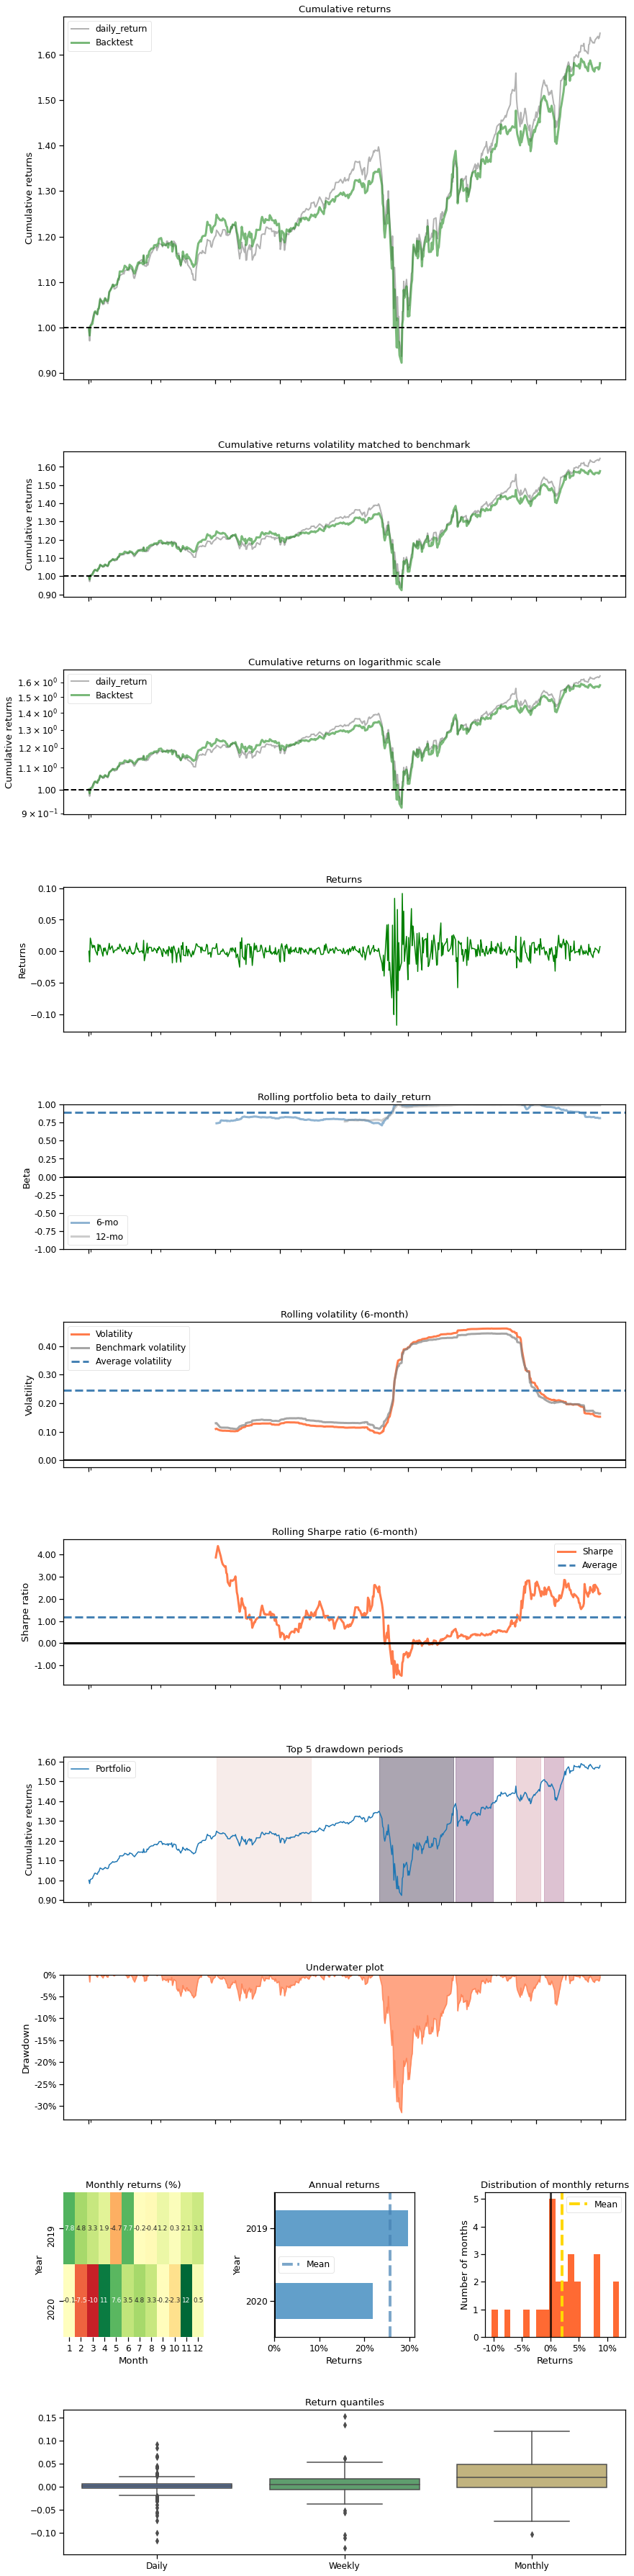

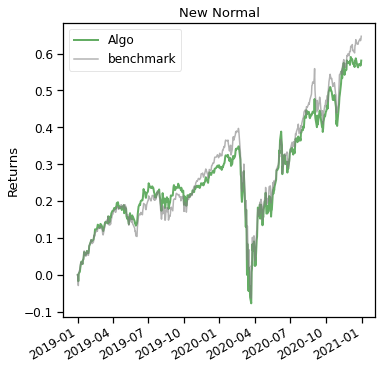

In [64]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)